# Modelli non lineari e non parametrici

In [1]:
# installare Pystan

# System
# ================================
import os

# Data import and manipulation
# ================================
import pandas as pd
import numpy as np
import re

# Modelling and forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
from fbprophet_inference.forecaster import Prophet

# Plots
# ==============================================================================
import seaborn as sn
from matplotlib import pyplot as plt

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

---
---
## 1 Passaggi preliminari
Importazione dati e split degli stessi in training, validation e test set

In [2]:

py_path = re.sub(r"\\", "/", os.environ["PYTHONPATH"])

In [3]:
data = pd.read_csv(py_path + "/Forecasting_Repository/data/interim/DF_SeasonalDummies.csv", index_col="time")
data.drop(columns="Unnamed: 0", inplace=True)
data.index = pd.to_datetime(data.index)
data

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,0,0,0,0,0,0,0,0,0,1
2018-12-31 20:00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,0,0,0,0,0,0,0,0,0,1
2018-12-31 21:00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,0,0,0,0,0,0,0,0,0,1


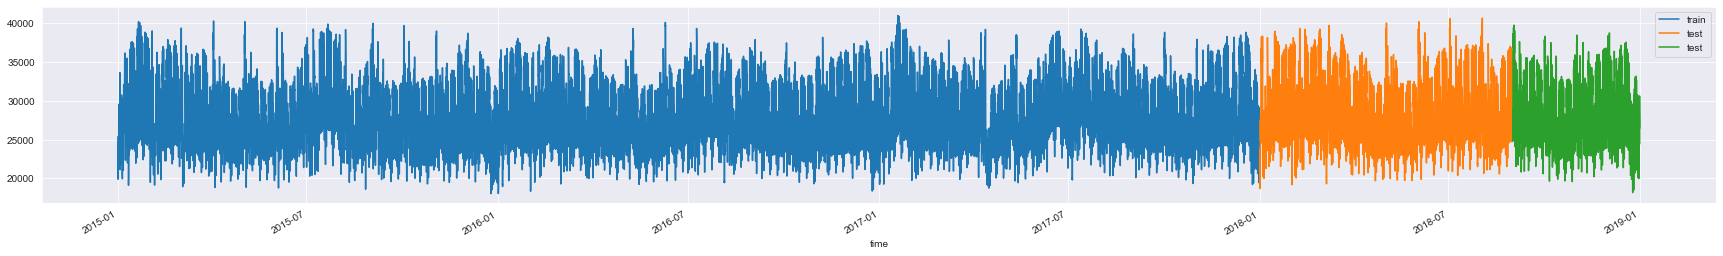

In [4]:
# Split data into train-val-test
# ==============================================================================
end_train = "2017-12-31 23:00:00"
start_validation = "2018-01-01 00:00:00"
end_validation = "2018-08-31 23:00:00"
start_test = "2018-09-01 00:00:00"

data_train = data.loc[: end_train, :]  # tre anni
data_validation = data.loc[start_validation: end_validation, :]  # otto mesi
data_test = data.loc[start_test:, :]  # quattro mesi --> così da poter cogliere la stagionalità quadrimestrale

fig, ax = plt.subplots(figsize=(30, 4))
data_train['total load actual'].plot(ax=ax, label='train')
data_validation['total load actual'].plot(ax=ax, label='test')
data_test['total load actual'].plot(ax=ax, label='test')
ax.legend()

---
---
## 2. MODELLING
Dati i risultati ottenuti con i precedenti modelli andiamo a utilizzare dei metodi più complessi ma più privi di limitazioni riguardanti la forma funzionale e altre caratteristiche particolari dei dati.
Andremo a sfruttare modelli costruiti appositamente per fare forecasting come il Light Gradient Boosting Machine e il Facebook Prophet.

---
### 2.1 Light Gradient Boosting model
Modello sviluppato da Microsoft che si basa sul classico boosting ma con delle migliorie a livello di prestazioni predittive e computazionali.

In [5]:
# Forecasters backtest with different lags
# ==============================================================================
lags = [2, 3, 25, 49, 2190]
metrics = []
predictions_list = []

for lag in lags:

    # Create forecaster
    forecaster = ForecasterAutoreg(
                    regressor = LGBMRegressor(random_state=123),  # light gradient boosting
                    lags      = lag
                    )

    # Backtest test data, 1 step
    metric, predictions = backtesting_forecaster(
                                 forecaster = forecaster,
                                 y          = data['total load actual'],
                                 initial_train_size = len(data.loc[:end_validation, 'total load actual']),
                                 exog=data.iloc[:,20:],
                                 fixed_train_size   = True,
                                 steps      = 24,
                                 refit      = False,
                                 metric     = 'mean_absolute_error',
                                 verbose    = False
                                 )

    metrics.append(metric)
    predictions_list.append(predictions)

In [6]:
# Fix index delle previsioni
adj_prediction_list = []
for pred in predictions_list:
    pred = pred.assign(time=data[start_test:].index)
    pred = pred.set_index("time")
    adj_prediction_list.append(pred)

adj_prediction_list

[                             pred
 time                             
 2018-09-01 00:00:00  27680.896205
 2018-09-01 01:00:00  25740.245395
 2018-09-01 02:00:00  24462.099226
 2018-09-01 03:00:00  23749.003375
 2018-09-01 04:00:00  23207.151241
 ...                           ...
 2018-12-31 19:00:00  32335.886011
 2018-12-31 20:00:00  32308.774867
 2018-12-31 21:00:00  31975.417398
 2018-12-31 22:00:00  29903.243325
 2018-12-31 23:00:00  24410.768904
 
 [2929 rows x 1 columns],
                              pred
 time                             
 2018-09-01 00:00:00  27714.791514
 2018-09-01 01:00:00  25756.431764
 2018-09-01 02:00:00  24388.703677
 2018-09-01 03:00:00  23739.358130
 2018-09-01 04:00:00  23365.352019
 ...                           ...
 2018-12-31 19:00:00  32138.764797
 2018-12-31 20:00:00  32630.394759
 2018-12-31 21:00:00  32290.213038
 2018-12-31 22:00:00  30288.421224
 2018-12-31 23:00:00  24298.497958
 
 [2929 rows x 1 columns],
                              pred

Assegnazione del riferimento temporale al dataframe con le previsioni fatte dal modello

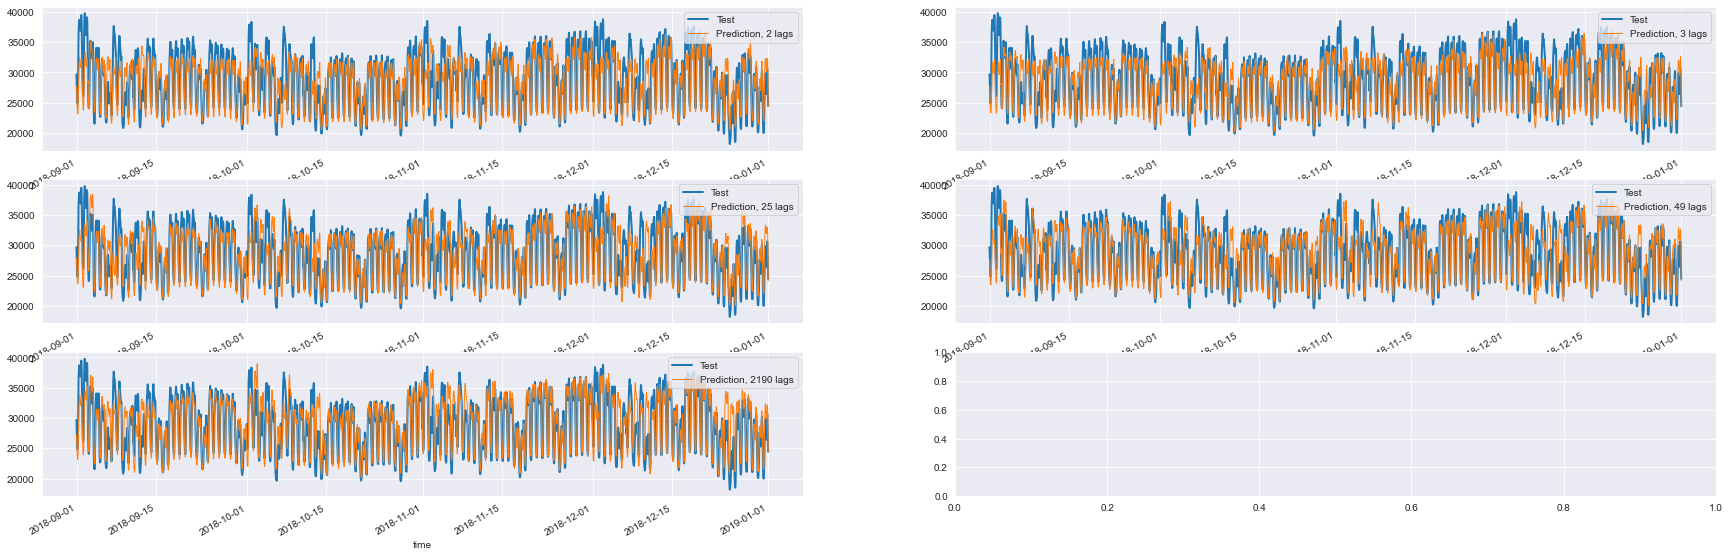

In [26]:
# Plot
# ==============================================================================
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(30, 10))

# Plot test predictions for different lags
for predictions, lag, ax in zip(adj_prediction_list, lags,  [x for v in axes for x in v]):
    data.loc[end_validation:, 'total load actual'].plot(ax=ax, linewidth=2, label='Test')
    predictions = predictions.rename(columns={'pred': f'Prediction, {lag} lags'})
    predictions.plot(ax=ax, linewidth=1).legend(loc='upper right')

In [8]:
for error, lag in zip(metrics, lags): print(f"LAG: {lag}   MSE: {error}")

LAG: 2   MSE: 1867.768224854288
LAG: 3   MSE: 1887.7298271146992
LAG: 25   MSE: 1769.4009644642235
LAG: 49   MSE: 1728.79117645995
LAG: 2190   MSE: 1552.1382102465475


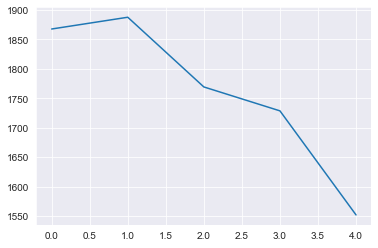

In [9]:
plt.plot(metrics)

Il modello migliore risulta essere quello che utilizza 2190 lag (cioè quattro mesi in ore); questo modello dovrebbe cogliere la stagionalità quadrimestrale della domanda energetica. In seconda posizione c'è il modello che utilizza 49 lag con una differenza di circa 200 nel MSE, valore molto piccolo. Bisogna decidere quanti lag utilizzare.
Il LGBM è comunque un modello estremamente veloce e finalizzato alla riduzione della varianza, quindi un modello molto propenso ai problemi di forecasting.
Ad ora è il modello migliore testato.

### 3 Facebook Prophet

In [10]:
m = Prophet()
m.fit(data_train)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=365)
m.predict(future)

ValueError: This is an inference only implementation. Use the full implementation to fit a model.

In [63]:
data.iloc[26303]  # "2017-12-31 23:00:00"

generation biomass                       278.0
generation fossil brown coal/lignite       0.0
generation fossil gas                   3552.0
generation fossil hard coal              926.0
generation fossil oil                    196.0
                                         ...  
month_8                                    0.0
month_9                                    0.0
month_10                                   0.0
month_11                                   0.0
month_12                                   1.0
Name: 2017-12-31 23:00:00, Length: 72, dtype: float64